In [13]:
!pip install optuna

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.7/757.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from Euler_1stOrderForward import getEulerBOLD
from signal_pytorch import csd
import json
import sys
import numpy as np
from scipy.signal import csd as scipy_csd
from torch.optim.lr_scheduler import ExponentialLR

device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
x_train_tensor, y_train_tensor = getEulerBOLD(noise=True, length=1000)
f2, csdy = csd(y_train_tensor, y_train_tensor, fs=100, nperseg=10000)
# y_train_tensor = np.loadtxt('/rds/general/user/ak1920/home/fyp/fyp/time_series/sub-001-PLCB-ROI0.txt', delimiter=',')
# f2, csdy = csd(y_train_tensor, y_train_tensor, fs=0.5, noverlap=None,  window='hamming', scaling='density', nfft=4096, nperseg=200)


def get_torch_rand(min, max):
    return torch.rand(()) * (max - min) + min


class TimeDomainModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(0.6))
        self.mu = nn.Parameter(torch.tensor(0.3))
        self.lamb = nn.Parameter(torch.tensor(0.3))
        self.beta = nn.Parameter(torch.tensor(0.8))
        self.psi = nn.Parameter(torch.tensor(1.0))
        self.phi = nn.Parameter(torch.tensor(0.4))
        self.chi = nn.Parameter(torch.tensor(0.4))


    def forward(self):
        #GET BOLD SIGNAL from PDCM WITH NOISE ADDED
        _, yhat = getEulerBOLD(phi=self.phi, psi=self.psi, chi=self.chi, sigma=self.sigma, mu=self.mu, lamb=self.lamb, alpha=1.0, beta=self.beta, noise=True, length=1000)
        yhat = torch.stack(yhat)
        return yhat
        # return torch.tensor(yhat, requires_grad=True)

    



def complex_mse_loss(output):
    f1, csdx = csd(output, output, fs=100, nperseg=10000)
    mse_real = torch.mean(torch.abs(torch.real(csdx) - torch.real(csdy))**2)
    mse_imaginary = torch.mean(torch.abs(torch.imag(csdx) - torch.imag(csdy))**2)
    loss = mse_real + mse_imaginary
    return loss


def train():
    model = TimeDomainModel().to(device)
    lr = 0.2
    n_epochs = 15
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = ExponentialLR(optimizer, gamma=0.8)

    model.train()
    losses = []
    for epoch in range(n_epochs):
        print("Epoch: ", epoch)
        yhat = model()
        loss = complex_mse_loss(yhat)
        print("Loss: ", loss)
        print("Params: ", model.phi, model.psi, model.chi, model.sigma, model.mu, model.lamb, model.beta)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())
        

    # Save losses array as JSON
    with open('losses.json', 'w') as f:
        json.dump(losses, f)

def train_multiple():
    lr = 0.2
    # scheduler = ExponentialLR(optimizer, gamma=0.9)

    num_initializations = 5
    models = [TimeDomainModel().to(device) for _ in range(num_initializations)]

# Train each instance separately using gradient descent
    num_epochs = 10
    model_losses = []
    for model in models:
        losses = []
        optimizer = optim.Adam(model.parameters(), lr=lr)
        for epoch in range(num_epochs):
            # Forward pass
            outputs = model()
            loss = complex_mse_loss(outputs)
            print(loss)
            losses.append(loss.item())
        
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model_losses.append(losses)

    # Evaluate the performance of each instance based on the final loss

    # Select the instance with the lowest loss
    best_model_idx = min(range(len(model_losses)), key=lambda i: model_losses[i][-1])
    print(best_model_idx, model_losses[best_model_idx][-1])

torch.set_printoptions(precision=8)
# train()

Input data is complex, switching to return_onesided=False


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import optuna
import json

def objective(trial):
    # Define search space for hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 3e-1, log=True)
    gamma = trial.suggest_float("gamma", 0.5, 0.99)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

    model = TimeDomainModel().to(device)
    n_epochs = 15
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ExponentialLR(optimizer, gamma=gamma)

    model.train()
    losses = []
    for epoch in range(n_epochs):
        yhat = model()
        loss = complex_mse_loss(yhat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
    print("Params: ", model.sigma, model.mu, model.lamb, model.phi, model.psi, model.chi, model.beta)
    
    return min(losses)  # Optimize for minimum loss

def train_optuna():
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)

    # Print best hyperparameters and best score
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Save losses array as JSON
    with open('losses_opt.json', 'w') as f:
        json.dump(trial.value, f)

    print("Best learning rate:", trial.params["lr"])

train_optuna()

[I 2024-06-08 17:38:51,893] A new study created in memory with name: no-name-e577ff9b-66b1-46c8-bfda-ea1be41267fd


Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False


In [ ]:
train()

Input data is complex, switching to return_onesided=False
0
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
1
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
2
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input da

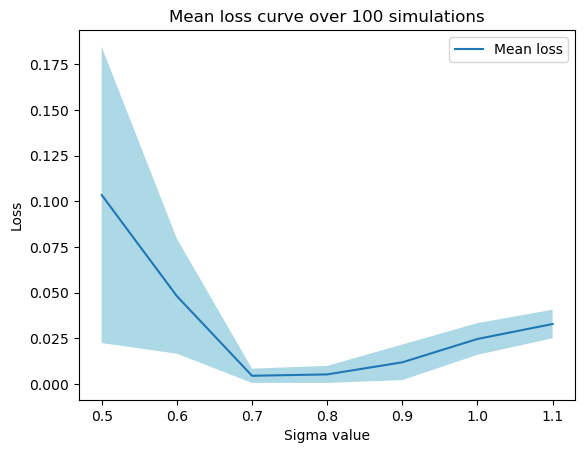

In [14]:
def complex_mse_loss(output):
    _, csdx = csd(output, output, fs=100,nperseg=10000)
    mse_real = torch.mean(torch.abs(torch.real(csdx) - torch.real(csdy))**2)
    mse_imaginary = torch.mean(torch.abs(torch.imag(csdx) - torch.imag(csdy))**2)
    loss = mse_real + mse_imaginary
    return loss


#fix alpha, change beta
# simulated signal -> alpha and beta 1 -> calculate csd
# observed_bold = np.loadtxt('./time_series/sub-001-PLCB-ROI0.txt', delimiter=',')
x_train_tensor, observed_bold  = getEulerBOLD(sigma=torch.tensor(0.8, requires_grad=True), mu=torch.tensor(0.3, requires_grad=True), lamb=torch.tensor(0.5, requires_grad=True), alpha=1.0, beta=torch.tensor(1.0, requires_grad=True), noise=True, length=500)

_, csdy = csd(observed_bold, observed_bold, fs=100,nperseg=10000)
all_losses = []
betas = np.arange(0.5, 1.5, 0.1)
mus = np.arange(0.1, 0.5, 0.1)
lambdas = np.arange(0.1, 1.0, 0.1)
sigmas = np.arange(0.5, 1.1, 0.1)
beta = 1.0
mu = 0.3
sigma = 0.8
lamb = 0.5
num_sims = 10

for i in range(num_sims):
    print(i)
    losses = []
    for sigma in sigmas:
            _, bold = getEulerBOLD(sigma=torch.tensor(sigma), mu=torch.tensor(mu), lamb=torch.tensor(lamb), alpha=1.0, beta=torch.tensor(beta), noise=True, length=500)
            bold = torch.stack(bold)
            loss = complex_mse_loss(bold)
            losses.append(loss.detach().numpy())
    all_losses.append(losses)

all_losses = np.array(all_losses)

mean_loss = np.nanmean(all_losses, axis=0)
std_deviation_loss = np.nanstd(all_losses, axis=0)

plt.xlabel('Sigma value')
plt.ylabel('Loss')
plt.title('Mean loss curve over 100 simulations')
plt.plot(sigmas, mean_loss, label='Mean loss')
plt.legend()
plt.fill_between(sigmas, mean_loss-std_deviation_loss, mean_loss+std_deviation_loss, facecolor = 'lightblue', label='standard deviation')
plt.show()


In [ ]:
def complex_mse_loss(output):
    f1, csdx = csd(output, output, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096, nperseg=1000)
    mse_real = torch.mean(torch.abs(torch.real(csdx) - torch.real(csdy))**2)
    mse_imaginary = torch.mean(torch.abs(torch.imag(csdx) - torch.imag(csdy))**2)
    loss = mse_real + mse_imaginary
    return loss


#fix alpha, change beta
# simulated signal -> alpha and beta 1 -> calculate csd
# observed_bold = np.loadtxt('./time_series/sub-001-PLCB-ROI0.txt', delimiter=',')
x_train_tensor, observed_bold  = getEulerBOLD(sigma=torch.tensor(0.8, requires_grad=True), mu=torch.tensor(0.3, requires_grad=True), lamb=torch.tensor(0.5, requires_grad=True), alpha=1.0, beta=torch.tensor(1.0, requires_grad=True), noise=True, length=1000)

_, csdy = csd(observed_bold, observed_bold, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096, nperseg=1000)

betas = np.arange(0.5, 1.5, 0.1)
mus = np.arange(0.1, 0.5, 0.1)
lambdas = np.arange(0.1, 1.0, 0.1)
sigmas = np.arange(0.5, 1.1, 0.1)
beta = 1.0
mu = 0.3
sigma = 0.8
lamb = 0.5
num_sims = 25

all_losses = np.zeros((len(lambdas), len(mus)))
for i in range(num_sims):
    print(i)
    losses = []
    for j, lamb in enumerate(lambdas):
        for k, mu in enumerate(mus):
            _, bold = getEulerBOLD(sigma=torch.tensor(sigma), mu=torch.tensor(mu), lamb=torch.tensor(lamb), alpha=1.0, beta=torch.tensor(beta), noise=True, length=1000)
            bold = torch.stack(bold)
            loss = complex_mse_loss(bold)
            all_losses[j, k] += loss.detach().numpy()


all_losses /= num_sims

# Plot heatmap
plt.imshow(all_losses, extent=[lambdas[0], lambdas[-1], mus[0], mus[-1]], aspect='auto', origin='lower')
plt.colorbar(label='Mean loss')
plt.xlabel('Lambdas')
plt.ylabel('Sigmas')
plt.title('Mean loss heatmap over 25 simulations')
plt.show()


[[0.23882231 0.15242148 0.04306389 0.02741657 0.00587636 0.00381303
  0.00435281]
 [0.11129234 0.0438594  0.01266647 0.00924941 0.00318859 0.00321079
  0.00393832]
 [0.05652633 0.02554164 0.01058949 0.00310841 0.00261685 0.00514947
  0.00472167]
 [0.01686291 0.00610771 0.0038519  0.00468755 0.00607622 0.00905434
  0.01163947]
 [0.01092217 0.00243396 0.0031402  0.00423764 0.00585623 0.00919851
  0.01299291]
 [0.00372465 0.00336456 0.00589241 0.00474088 0.00942794 0.01457278
  0.01853781]
 [0.00185238 0.00322738 0.00527994 0.00899173 0.01183922 0.01630662
  0.02035102]]


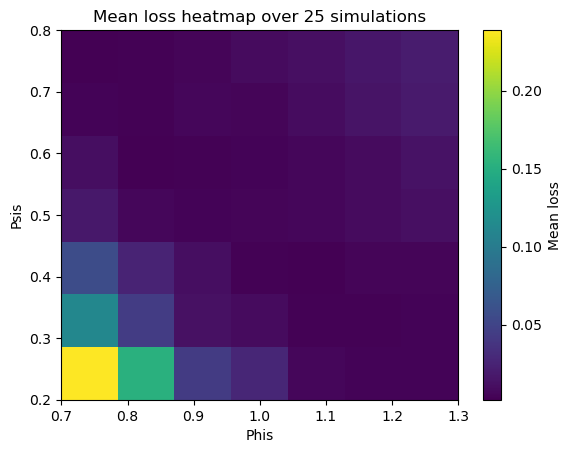

In [4]:
## betas = np.arange(0.5, 1.5, 0.1)
betas = np.arange(0.5, 1.5, 0.1)
mus = np.arange(0.7, 1.3, 0.1)
lambdas = np.arange(0.2, 0.6, 0.1)
sigmas = np.arange(0.2, 0.9, 0.1)
phis = np.arange(1.4, 2.4, 0.1)
psis = np.arange(0.2, 1.0, 0.1)
all_losses = np.loadtxt(f"loss_graph_mu_sigma.txt", delimiter=',')
print(all_losses)
# Plot heatmap
plt.imshow(all_losses, extent=[mus[0], mus[-1], sigmas[0], sigmas[-1]], aspect='auto', origin='lower')
plt.colorbar(label='Mean loss')
plt.xlabel('Phis')
plt.ylabel('Psis')
plt.title('Mean loss heatmap over 25 simulations')
plt.show()

In [2]:
import json

# Read JSON file
with open("losses-simulated.json", 'r') as json_file:
    losses = json.load(json_file)


epochs = np.arange(len(losses))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.plot(epochs, losses, label='Training epoch loss')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'losses-simulated.json'

In [8]:
observed_bold = np.loadtxt('/rds/general/user/ak1920/home/fyp/fyp/time_series/sub-002-PLCB-ROI0.txt' , delimiter=',')
observed_bold = torch.from_numpy(observed_bold)
observed_bold = observed_bold / observed_bold.std()
fo, po = csd(observed_bold, observed_bold, fs=0.5, nperseg = 64)


Input data is complex, switching to return_onesided=False


Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False


(0.0, 0.1)

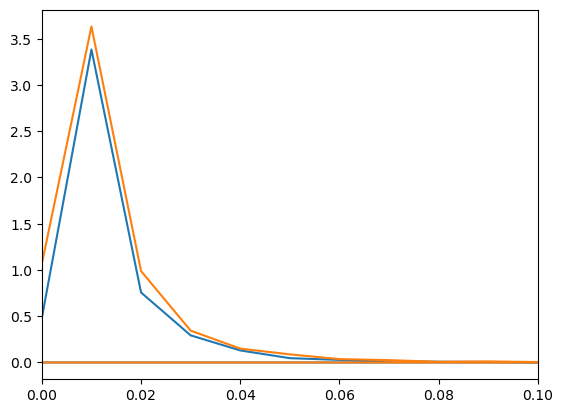

In [10]:
_, y = getEulerBOLD(sigma=1.07831717,mu=0.94819546, lamb=0.48385170, beta=1.03255028, phi=1.83636320, 
                    psi=0.64763081,chi=0.44030708, noise=True, length=1000) 


        self.sigma = nn.Parameter(torch.tensor(0.9))
        self.mu = nn.Parameter(torch.tensor(0.8))
        self.lamb = nn.Parameter(torch.tensor(0.3))
        self.beta = nn.Parameter(torch.tensor(0.2))
        self.psi = nn.Parameter(torch.tensor(0.5))
        self.phi = nn.Parameter(torch.tensor(2.0))
        self.chi = nn.Parameter(torch.tensor(0.3))

sigma=0.5, mu=0.4, lamb=0.2, c=0.25,
                 psi=0.6, phi=1.5, chi=0.6,
    
y = torch.stack(y)
y = y / torch.std(y)
f1, csdx = csd(y, y, fs=100, nperseg = 10000)
_, y0 = getEulerBOLD(noise=True, length=1000)
y0 = torch.stack(y0)
y0 = y0 / torch.std(y0)
f2, csdy = csd(y0, y0, fs=100, nperseg = 10000)

# sp = np.loadtxt("final_spectrum_simulated.txt", delimiter=',', dtype=complex)
plt.plot(f1.detach(), csdx.detach())
plt.plot(f2.detach(), csdy.detach())
# sp = np.loadtxt("final_spectrum_sub-001-LSD-ROI2.txt", delimiter=',', dtype=complex)
# plt.plot(fo, sp)
# plt.plot(fo, po)
plt.xlim(0, 0.1)